In [5]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers requests beautifulsoup4
#!pip install torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118
!pip install torchmetrics
!pip install wordcloud

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.1+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [1]:
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

from transformers import BertTokenizer, AutoModelForSequenceClassification, get_scheduler
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from distutils.version import LooseVersion as LV

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import Beautiful Soup package
import requests
from bs4 import BeautifulSoup

import torch

if torch.cuda.is_available():
    # If CUDA is available, set the device to CUDA and get the device name
    device = torch.device('cuda')
    devicename = '[' + torch.cuda.get_device_name(0) + ']'
else:
    # If CUDA is not available, set the device to CPU
    device = torch.device('cpu')
    devicename = ""

# Print PyTorch version and the selected device (CPU or GPU)
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)

# Check if the installed PyTorch version is at least 1.0.0
assert torch.__version__ >= "1.0.0"


sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# rcParams['figure.figsize'] = 12, 8


Using PyTorch version: 2.2.1+cu121 Device: cuda [Tesla T4]


Initialize and load Drive

In [2]:
# BASE_FOLDER = '.'

from google.colab import drive
drive.mount('/content/drive')

#BASE_FOLDER = '/content/drive/MyDrive/mscprojects'
BASE_FOLDER = '/content/drive/MyDrive/ProjectDatasets'


Mounted at /content/drive


SCRAPE REVIEWS

In [ ]:
# URL for querying the IMDb website for reviews of the movie with IMDb ID "tt0111161" (The Shawshank Redemption)

# tt0111161 - The Shawshank Redemption
# tt0056172 - Lawrence of Arabia
# tt0061722 - The Graduate
# tt0114709 - Toy Story
# tt0114148 - Pocahontas
# tt0113189 - GoldenEye
# tt0113101 - Four Rooms
# tt0113161 - Get Shorty
# tt0112722 - Copycat
# tt0115012 - Shanghai Triad

######
# tt0114746 - Twelve Monkeys
# tt0114048 - Operation Dumbo Drop
# tt0112431 - Babe
# tt0120222 - Stranger in the house
# tt0112818 - Dead Man Walking
# tt0110428 - The Madness of King George
# tt0114279 - Richard III
# tt0114369 - Seven
# tt13717946 - The Usual Suspects
# tt0114576 - Sudden Death


#######

# tt0115493 - Alaska
# tt0068646 - The Godfather ##
# tt0468569 - The Dark Knight
# tt0804503 - Mad Men
# tt0050083 - Twelve Angry Men
# tt0167261 - The Lord of the Rings: The Two Towers
# tt0060196 - The Good, the Bad and the Ugly
# tt0083131 - Stripes
# tt0033891 - Meet John Doe
# tt0105236 - Reservoir Dogs
# tt0120094 - Selena
# tt0119174 - The Game



url = "https://www.imdb.com/title/tt0119174/reviews/_ajax?ref_=undefined&paginationKey={}"

# Initialize pagination key
key = ""

# Initialize dictionary to store extracted information
data = {"movie": [], "title": [], "review": [], "rating": []}

# Add movie name to the dictionary
data["movie"] = []

n = 0

# Main loop to scrape reviews
while n < 1000:
    # Send GET request to the URL with pagination key
    response = requests.get(url.format(key))
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the pagination key
    pagination_key = soup.find("div", class_="load-more-data")

    # Check if pagination key exists
    if not pagination_key:
        break

    # Update the pagination key for next iteration
    key = pagination_key["data-key"]

    # Extract review data from the page
    for title, review, rating in zip(
        soup.find_all(class_="title"),
        soup.find_all(class_="text show-more__control"),
        soup.find_all(class_="rating-other-user-rating")
    ):
        # Append extracted data to the dictionary
        data["movie"].append("The Game")
        data["title"].append(title.get_text(strip=True))
        data["review"].append(review.get_text())
        data["rating"].append(rating.get_text(strip=True) if rating else "N/A")

    # Increment the loop counter
    n += 1


In [ ]:
df_review = pd.DataFrame(data)
df_review.info()

In [ ]:
# Split the values in the "rating" column based on the "/" delimiter and expand them into separate columns
df_review[["numerator", "denominator"]] = df_review["rating"].str.split("/", expand=True)

# Display a sample of 12 rows from the DataFrame to verify the changes
df_review.sample(8)

,movie,title,review,rating,numerator,denominator
325,The Game,Super entertaining,This is definitely a roller-coaster film that ...,2/10,2,10
511,The Game,"Brilliant directing, flawless acting, fine poi...",Well... what can I say? The movie gets a stell...,8/10,8,10
706,The Game,Good but could be better,Classic. I expected better directing although ...,5/10,5,10
194,The Game,"Cheap shots, all blanks","A movie with pretensions of profundity, shooti...",2/10,2,10
35,The Game,Very Entertaining Thriller,This movie is often described as exceptional a...,8/10,8,10
143,The Game,Fincher's Followup to Seven,Wealthy San Francisco financier Nicholas Van O...,9/10,9,10
535,The Game,Finishes strong,I would sum The Game up like this: it moved al...,7/10,7,10
555,The Game,A game better watched than played,How many films have you seen that keep you gue...,7/10,7,10


In [ ]:
# Convert "numerator" column to integer and assign it to a new column "movie_rating"
df_review["movie_rating"] = df_review["numerator"].astype(int)

# Drop "numerator" and "denominator" columns from the DataFrame
df_r = df_review.drop(['numerator', 'denominator'], axis=1)

# Display the first few rows of the resulting DataFrame
df_r.sample(7)

,movie,title,review,rating,movie_rating
287,The Game,one dark flick,This is a dark movie with a sick and twisted p...,10/10,10
354,The Game,Excellent thriller,This is by far one of the best thrillers I've ...,7/10,7
32,The Game,Some Game,David Fincher directed this twisty thriller th...,4/10,4
251,The Game,The Game!,The Game is a very good film that has a good c...,7/10,7
46,The Game,This could have been a DISASTER!!!,The plot (not the writing) of this film is rid...,6/10,6
660,The Game,thoroughly captivated,"When I first saw this film, I truly believed I...",9/10,9
97,The Game,It had me fooled.,Possible Spoilers ahead\nThe fact that this fi...,8/10,8


In [ ]:
def to_sentiment(rating):
    # Convert the rating to an integer
    rating = int(rating)

    # Map numerical ratings to sentiment labels
    if rating <= 2:
        return 1  # Negative
    elif rating <= 4:
        return 2  # Slightly Negative
    elif rating == 5:
        return 3  # Neutral
    elif rating <= 7:
        return 4  # Slightly Positive
    elif rating <= 10:
        return 5  # Positive

In [ ]:
df_r['score'] = df_r.movie_rating.apply(to_sentiment)
df_r.sample(7)

#data_file['label'] = data_file.rating.apply(to_sentiment)
#data_file.sample(10)

,movie,title,review,rating,movie_rating,score
340,The Game,"What is real and what isn't, and how do you kn...",Nicholas Van Orton (Douglas) is a very wealthy...,8/10,8,5
508,The Game,The Game review,The Game is a film starring Michael Douglas as...,8/10,8,5
557,The Game,"Douglas at his neurotic best, yet again",Chock-full of twists and turns till the very e...,7/10,7,4
210,The Game,The Game is a killer!!!,Excellent movie.Simply great.David Fincher is ...,8/10,8,5
471,The Game,The Game is Fun but it Isn't Fincher's Best,The psychological thriller The Game is directe...,10/10,10,5
85,The Game,Underappreciated,"Released in 1997, just in between two of Finch...",8/10,8,5
242,The Game,It keeps getting better,I just saw this movie again on cable and it di...,9/10,9,5


Label Scraped Reviews

In [ ]:
def score_to_sentiment(score):
    # Map numerical sentiment scores to sentiment labels
    if score == 1:
        return "negative"
    elif score == 2:
        return "slightly negative"
    elif score == 3:
        return "neutral"
    elif score == 4:
        return "slightly positive"
    else:
        return "positive"

In [ ]:
df_r['sentiment'] = df_r.score.apply(score_to_sentiment)
df_r.sample(7)

,movie,title,review,rating,movie_rating,score,sentiment
115,The Game,a thriller with enough paranoia and gusto to b...,"The Game is basically an elaborate hoax, but u...",9/10,9,5,positive
99,The Game,Well what else would expect from the man who g...,I really had not the slightest clue what I pur...,8/10,8,5,positive
7,The Game,A classic thriller that is aging well,I remember liking it a lot when it came out an...,9/10,9,5,positive
625,The Game,Music film...,What's that music when Nickolas enter at home ...,7/10,7,4,slightly positive
638,The Game,this could have been awesome...,"I auditioned for this movie, a small speaking ...",10/10,10,5,positive
349,The Game,Horrible,Horrible ending to what could have been a supe...,8/10,8,5,positive
450,The Game,Good movie but it was also way too unrealistic...,The greatest hole is that it was just too dang...,7/10,7,4,slightly positive


In [ ]:
df_r['review'].iloc[49]
# df['review'].iloc[788]


'Intriguing, but flawed, thriller.The Game relies heavily on a clever plot, and for you to suspend disbelief. The clever plot is maybe too clever for its own good, creating plot holes. Eventually, after the umpteenth twist the whole thing just feels implausible.This said, it is quite entertaining - a roller-coaster ride of a movie. Very original too.Solid performance from Michael Douglas in the lead role, in a role that suits him best (ie crime thriller). Good support from Deborah Kara Unger and Sean Penn.'

Generate CSv file and save on th drive

In [ ]:
# sentiment_sentences = pd.DataFrame({'reviews':df_review,'score':score, 'sentiment': sentiment}).to_csv('/content/drive/MyDrive/ProjectDatasets/ms_reviews.csv', index=False)
df_r.to_csv('/content/drive/MyDrive/ProjectDatasets/thegame.csv',index=False)

In [ ]:
# data_file = pd.read_csv('/content/drive/MyDrive/ProjectDatasets/movielens100k_details.csv', encoding="utf-8")
# data_file.sample(10)

SENTIMENT ANALYSIS STARTS

Configuration

In [4]:
# Define the path to your IMDb dataset CSV file
DATA_PATH = '/content/drive/MyDrive/ProjectDatasets/imdb/scored/msc_reviews_dataset.csv'
SAVED_MODEL_PATH = '/content/drive/MyDrive/'
BERT_CHECKPOINT = 'nlptown/bert-base-multilingual-uncased-sentiment' # bert-base-uncased or nlptown/bert-base-multilingual-uncased-sentiment

MAX_LEN = 512 #Specifies the maximum length of input sequences. Sequences longer than this will be truncated, and sequences shorter than this will be padded. - 128
BATCH_SIZE = 8 #the number of samples to process in one iteration of training. 8 or 16 or 32
NUM_CLASSES = 5 #the number of classes in your classification task.
LEARNING_RATE = 0.001  #Sets the rate at which your model's parameters are updated during training - 2e-5 or 1e-4
NUM_EPOCHS= 10 #Defines the number of times the entire training dataset will be passed forward and backward through the neural network. - 5 or 10
NUM_WARMUP_STEPS = 0 # Specifies the number of initial optimization steps where the learning rate increases linearly from 0 to its initial value.

Utilities

Load Data

In [10]:
# read data and remove duplicates
df = (pd.read_csv(DATA_PATH).drop_duplicates())

In [11]:
# check first few samples
print(f'Numbers of samples: {len(df)}')
df.head()

Numbers of samples: 57535


,review,scores
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,4
2,I thought this was a wonderful way to spend ti...,3
3,Basically there's a family where a little boy ...,2
4,"Petter Mattei's ""Love in the Time of Money"" is...",3


Take Sample data

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/ProjectDatasets/labelled_reviews.csv', encoding="utf-8")
df.sample(5)

,review,scores
3814,Man oh man! What a piece of crummy film-making...,0
52597,like bit satellite dish comes water,4
49542,"Up until the last few minutes of the movie, I ...",1
53769,still crime drama got whole bunch hype first c...,4
53591,man perfect movie read every surprised negativ...,4


Check full text sample

In [ ]:
df['review'].iloc[20]

"After the success of Die Hard and it's sequels it's no surprise really that in the 1990s, a glut of 'Die Hard on a .....' movies cashed in on the wrong guy, wrong place, wrong time concept. That is what they did with Cliffhanger, Die Hard on a mountain just in time to rescue Sly 'Stop or My Mom Will Shoot' Stallone's career.<br /><br />Cliffhanger is one big nit-pickers dream, especially to those who are expert at mountain climbing, base-jumping, aviation, facial expressions, acting skills. All in all it's full of excuses to dismiss the film as one overblown pile of junk. Stallone even managed to get out-acted by a horse! However, if you an forget all the nonsense, it's actually a very lovable and undeniably entertaining romp that delivers as plenty of thrills, and unintentionally, plenty of laughs.<br /><br />You've got to love John Lithgows sneery evilness, his tick every box band of baddies, and best of all, the permanently harassed and hapless 'turncoat' agent, Rex Linn as Travers

countplot

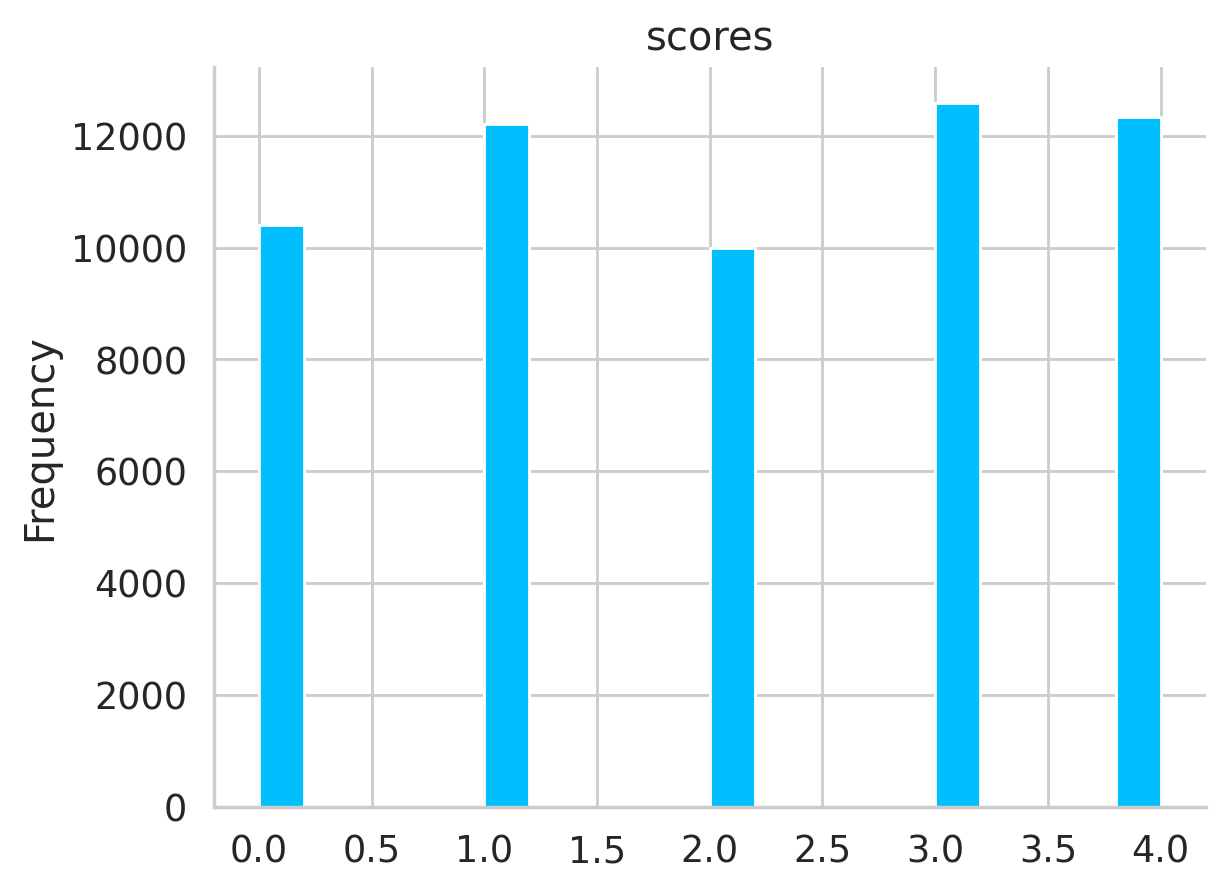

In [ ]:
# sns.set(style = "darkgrid" , font_scale = 1.0)
# sns.countplot(df.scores)

# @title score
import seaborn as sns
from matplotlib import pyplot as plt

df['scores'].plot(kind='hist', bins=20, title='scores')
plt.gca().spines[['top', 'right',]].set_visible(False)

Data Visualization & Preprocessing

In [ ]:
df.describe()

,scores
count,57535.000000
mean,2.073799
std,1.416489
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [ ]:
from matplotlib import pyplot as plt
df_review['movie_rating'].plot(kind='hist', bins=20, title='movie_rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

Check for  Missing Values

In [ ]:
df.isna().sum() # Checking for any missing values

review    1
scores    0
dtype: int64

Fill in Missing Values when there was one

In [ ]:
df['review'].fillna('Unknown', inplace=True)
df.head()

,review,scores
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,4
2,I thought this was a wonderful way to spend ti...,3
3,Basically there's a family where a little boy ...,2
4,"Petter Mattei's ""Love in the Time of Money"" is...",3


Check for duplicates

In [ ]:
print(f'number of samples:{len(df.review)}')
print(f'number of unique reviews: {df.review.nunique()}')
print(f'percentage of duplicates: {(len(df.review) - df.review.nunique()) / len(df.review)*100}%')

number of samples:57535
number of unique reviews: 57478
percentage of duplicates: 0.09907013122447206%


Is Target Balanced?

In [ ]:
df.sentiment.value_counts(normalize = True)

sentiment
slightly positive    0.218858
positive             0.214374
slighly negative     0.212114
negative             0.180846
neutral              0.173807
Name: proportion, dtype: float64

Remove Stopwords

In [15]:
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Data Preparation

Cleaning

In [16]:
# For cleaning reviews
def clean_text(text):
    """Removes extra whitespaces and html tags from text."""
    # remove weird spaces
    text =  " ".join(text.split())
    # remove html tags
    text = re.sub(r'<.*?>', '', text)
    return text

def strip_html(text):
    if isinstance(text, str):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    else:
        return ""

#def strip_html(text):
#   soup = BeautifulSoup(text, "html.parser")
#    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    return text

# Assuming 'df' is defined and contains the 'review' column
df['review'] = df['review'].apply(denoise_text)

<ipython-input-16-b5d236af3491>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [6]:
import torch.nn.functional as F
from torchmetrics import Accuracy

# Class for custom dataset
class CustomDataset(Dataset):
    def __init__(self, review, target, tokenizer, max_len, clean_text=None):
        self.clean_text = clean_text
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, idx):
      # y = torch.tensor(self.target[idx], dtype=torch.long) - 1 # Adjust if class indices start from 1
        y = torch.tensor(self.target[idx], dtype=torch.long)
        X = str(self.review[idx])
        if self.clean_text:
            X = self.clean_text(X)

        encoded_X = self.tokenizer(
            X,
            return_tensors = 'pt',
            max_length = self.max_len,
            truncation=True,
            padding = 'max_length'
            )

        # One-hot encoding for the target labels
        #y_one_hot = torch.nn.functional.one_hot(y)
        # One-hot encoding for the target labels
        #y_one_hot = torch.nn.functional.one_hot(y, num_classes=NUM_CLASSES).float().squeeze()


        return {'input_ids': encoded_X['input_ids'].squeeze(),
                'attention_mask': encoded_X['attention_mask'].squeeze(),
                'labels': y}



# Training loop for one epoch
def train_epoch(model, dataloader, optimizer, scheduler, device, progress_bar):

    losses = []
    accuracies = []

    model.train()
    for batch in dataloader:

        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        #loss = outputs.loss
        # Compute loss using CrossEntropyLoss
        loss = F.cross_entropy(outputs.logits, batch['labels'].to(device))

        loss.backward()
        optimizer.step()
        scheduler.step()

        #preds = torch.argmax(outputs.logits, dim=1) + 1 # if class start from 1
        preds = torch.argmax(outputs.logits, dim=1)
        acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)(preds.to(device), batch['labels'].to(device))
        #acc = Accuracy().to(device)(preds.to(device), batch['labels'].to(device))
        #acc = torch.sum(preds == batch['labels']) / len(preds)
        accuracies.append(acc)
        losses.append(loss)

        progress_bar.update(1)

    return torch.tensor(losses, dtype=torch.float).mean().item(), torch.tensor(accuracies).mean().item()


# Evaluation loop
def eval_epoch(model, dataloader, device):
    losses = []
    accuracies = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:

            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            #loss = outputs.loss
            # Compute loss using CrossEntropyLoss
            loss = F.cross_entropy(outputs.logits, batch['labels'].to(device))

            preds = torch.argmax(outputs.logits, dim=1)
            #acc = torch.sum(preds == batch['labels']) / len(preds)
            acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)(preds.to(device), batch['labels'].to(device))
            accuracies.append(acc)
            losses.append(loss)

        return torch.tensor(losses, dtype=torch.float).mean().item(), torch.tensor(accuracies).mean().item()


Evaluation function on Test Dataset

In [7]:
# For final evaluation on test set
def test(model, dataloader, device):
    y_preds = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:

            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

           # y_preds.extend( torch.argmax(outputs.logits, dim=1) + 1 ) # Code modified for one-based
            y_preds.extend( torch.argmax(outputs.logits, dim=1) )
            y_true.extend( batch['labels'])

        return y_preds, y_true


WORD CLOUD

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Word Cloud - Positive

In [ ]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 600 , height = 350).generate(" ".join(df[df.scores == 4].review))
plt.imshow(wc , interpolation = 'bilinear')

Word Cloud - Neutral

In [ ]:
plt.figure(figsize = (20,20)) # Neutral Review Text
wc = WordCloud(max_words = 2000 , width = 600 , height = 400).generate(" ".join(df[df.scores == 2].review))
plt.imshow(wc , interpolation = 'bilinear')

Number of Characters

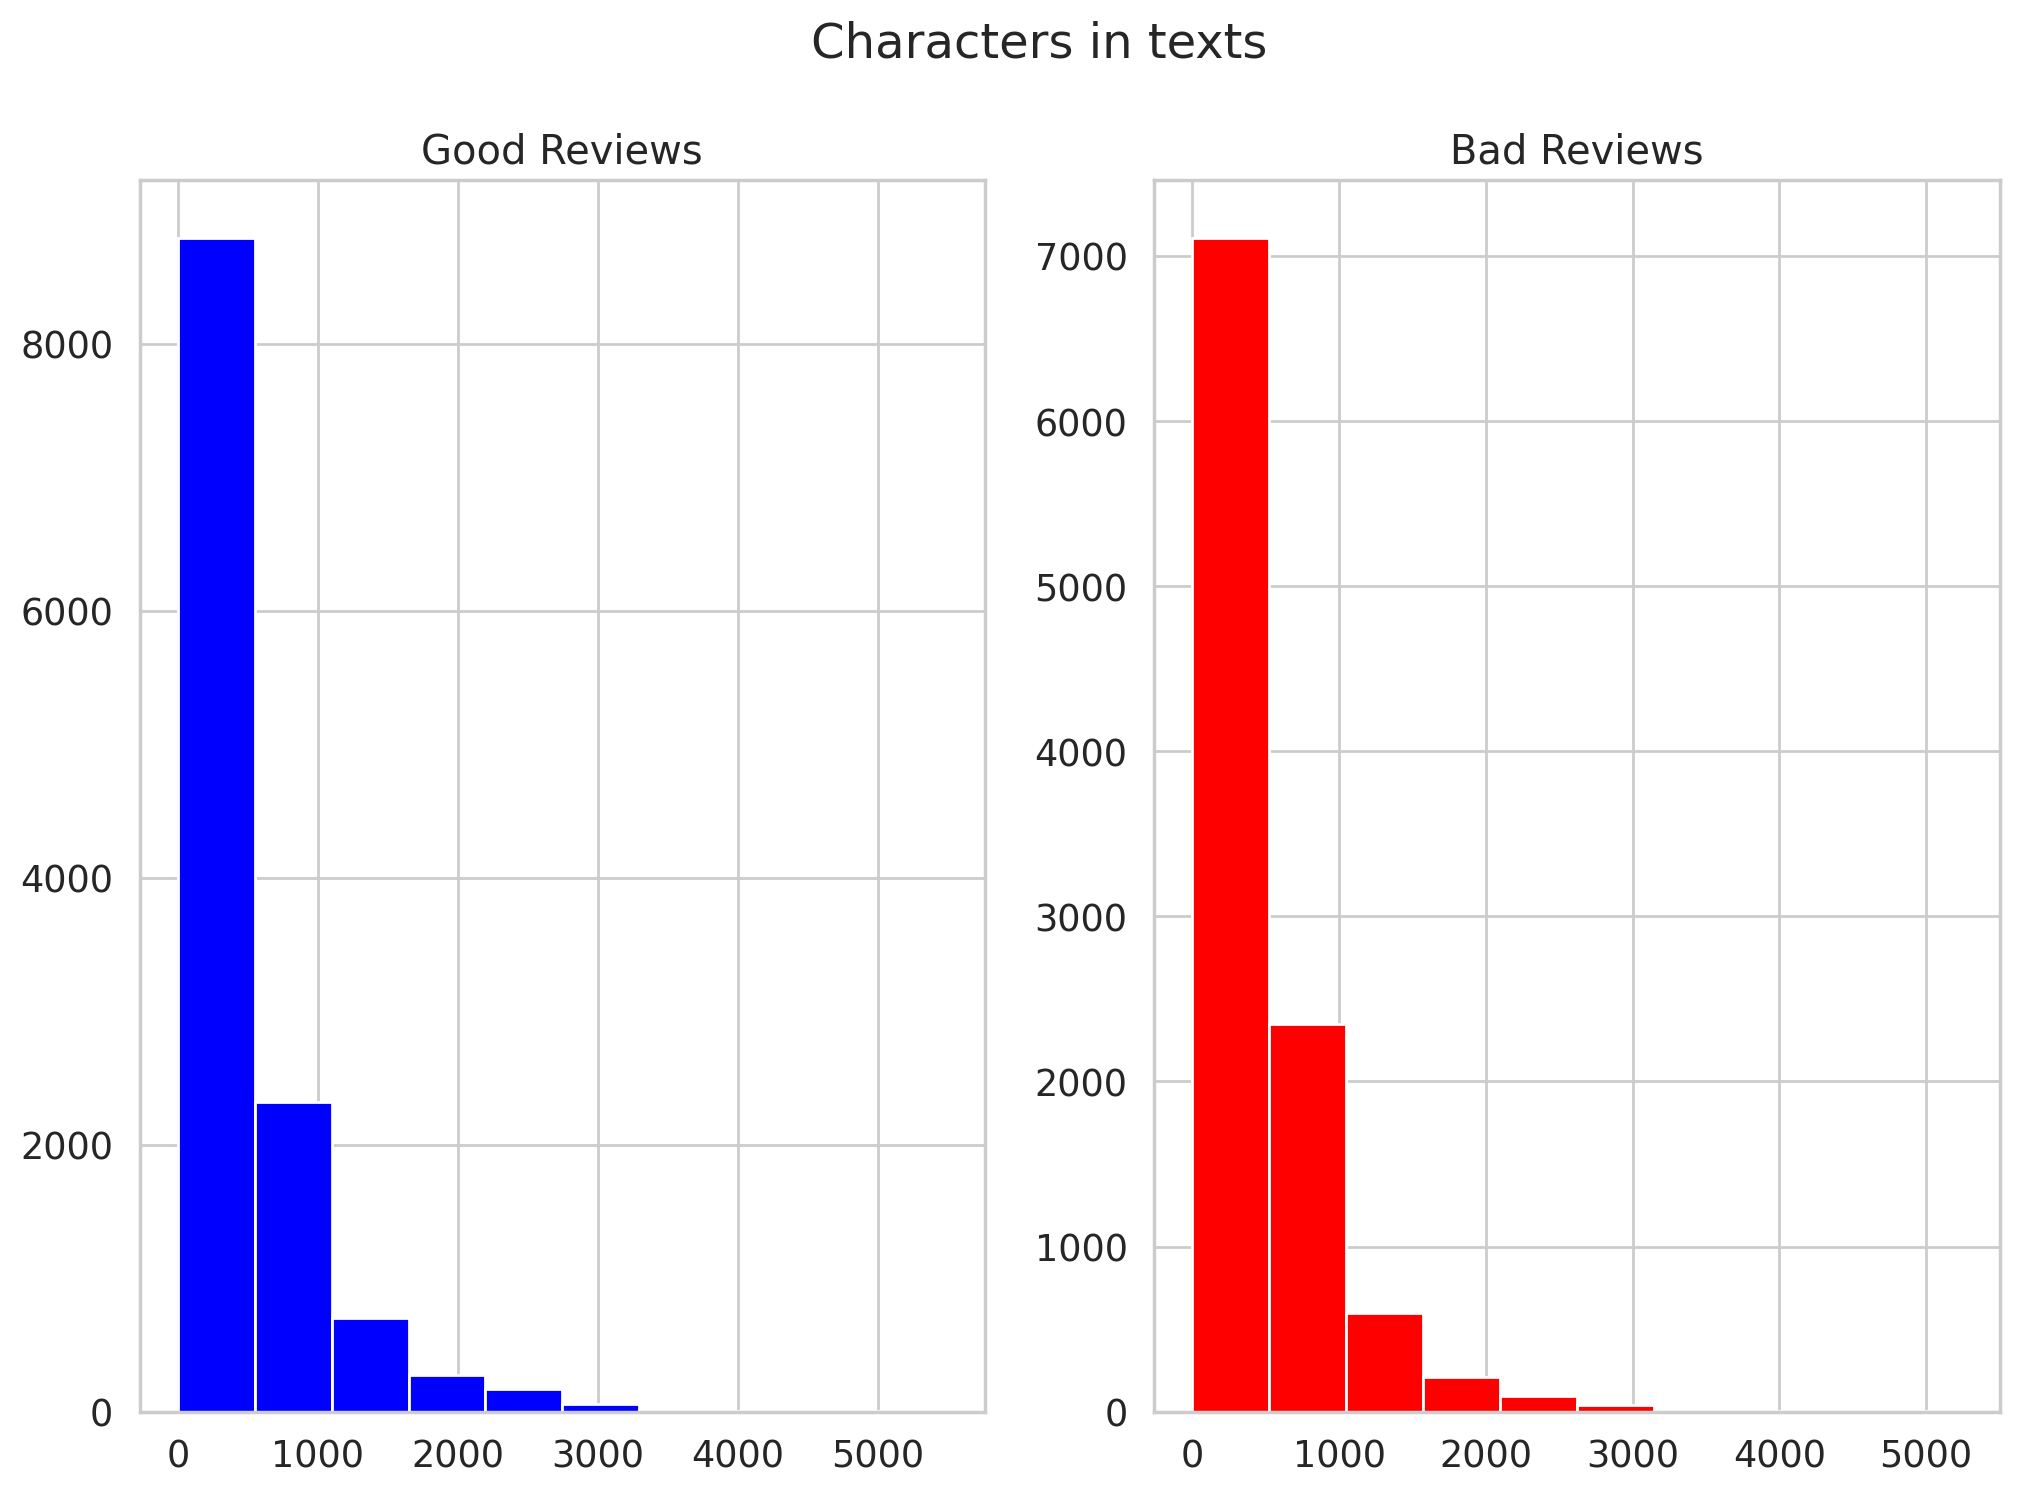

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['scores']==4]['review'].str.len()
ax1.hist(text_len,color='blue')
ax1.set_title('Good Reviews')
text_len=df[df['scores']==0]['review'].str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Bad Reviews')
fig.suptitle('Characters in texts')
# plt.show()

Covert Rating to Scores - METHOD 1

In [ ]:
def to_sentiment(rating):
    # Convert the rating to an integer
    rating = int(rating)

    # Map numerical ratings to sentiment labels
    if rating <= 2:
        return 0  # Negative
    elif rating <= 4:
        return 1  # Slightly Negative
    elif rating == 5:
        return 2  # Neutral
    elif rating <= 7:
        return 3  # Slightly Positive
    elif rating <= 10:
        return 4  # Positive

In [ ]:
df['scores'] = df_r.movie_rating.apply(to_sentiment)
df.sample(7)

Use Sentiment to convert to scores - BEST AND FASTER METHOD 2

In [ ]:
# transform targets to  integers
# df['score'] = df['sentiment'].apply(lambda x: score_to_sentiment(x))
# df['score'] = df['review'].apply(lambda x: sentiment_score(x[:512]))
df['scores'] = df['sentiment'].apply(lambda x: 0 if x == "negative" else (1 if x == "slightly negative" else (2 if x == "neutral" else (3 if x == "slightly positive" else (4 if x == "positive" else 0)))))
df.sample(6)


,movie,title,review,rating,movie_rating,score,sentiment,scores
23028,The Lord of the Rings: The Two Towers,Highly overrated,boyfriend disagree strongly thought lotr pt la...,10/10,10,5,positive,4
1726,Twelve Monkeys,Watch it again ... and again ... and again,terry gilliam one finest filmmakers movie unde...,8/10,8,5,positive,4
1687,Twelve Monkeys,So you're telling me those people in the menta...,rented monkeys day huge bruce willis fan heard...,9/10,9,5,positive,4
9852,The Godfather,The Godfather is beyond amazing,seen many amazing movies many well godfather b...,10/10,10,5,positive,4
18349,The Dark Knight,Best movie ever,movie build something one else could far best ...,10/10,10,5,positive,4
25839,Selena,What happened?,scrolled vain searching intelligent review sto...,1/10,1,1,negative,0


Save New file

In [ ]:
# sentiment_sentences = pd.DataFrame({'reviews':df_review,'score':score, 'sentiment': sentiment}).to_csv('/content/drive/MyDrive/ProjectDatasets/ms_reviews.csv', index=False)
#df.to_csv('/content/drive/MyDrive/ProjectDatasets/new_score_label.csv',index=False)

TRAINING, VALIDATION & TEST SPLITS

In [12]:
# Train, validation and test splits

train_df, test_val_df = train_test_split(df, test_size=0.3, stratify=df['scores'], random_state=20)

val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df['scores'], random_state=20)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f'Number of samples in train set: {len(train_df)}')
print(f'Number of samples in validation set: {len(val_df)}')
print(f'Number of samples in test set: {len(test_df)}')

Number of samples in train set: 40274
Number of samples in validation set: 8630
Number of samples in test set: 8631


Tokenization

In [13]:
#tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
#tokenizer = BertTokenizer.from_pretrained(BERT_CHECKPOINT)
#tokenizer = AutoTokenizer.from_pretrained(BERT_CHECKPOINT, do_lower_case=True)
tokenizer = AutoTokenizer.from_pretrained(BERT_CHECKPOINT, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [17]:
dfs = {'train':train_df, 'val':val_df, 'test':test_df}
dataloaders = {}

for data_f in dfs:
    should_shuffle = True if data_f == 'train' else False
    dataloaders[data_f] = DataLoader(
    CustomDataset(dfs[data_f]['review'],  dfs[data_f]['scores'], tokenizer=tokenizer, max_len=MAX_LEN, clean_text=clean_text),
    batch_size=BATCH_SIZE, shuffle=should_shuffle
    )

In [18]:
# Testing if batch loads properly
for batch in dataloaders['train']:
    x, y = batch['input_ids'], batch['labels']
    print({k:v.shape for k, v in batch.items()})
    break

{'input_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8])}


TRAINING

In [20]:
## SETUP

# model
# model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment',problem_type="multi_label_classification",num_labels=NUM_CLASSES)
# model = AutoModelForSequenceClassification.from_pretrained(BERT_CHECKPOINT,problem_type="multi_label_classification",num_labels=NUM_CLASSES)
model = AutoModelForSequenceClassification.from_pretrained(BERT_CHECKPOINT,num_labels=NUM_CLASSES)

model.to(device)

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

# scheduler
# num_training_steps = 100
num_training_steps = NUM_EPOCHS * len(dataloaders['train'])
scheduler = get_scheduler('linear',optimizer=optimizer,num_warmup_steps=NUM_WARMUP_STEPS,num_training_steps=num_training_steps)

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

TEST

In [21]:
# Test

outputs = model(**{k:v.to(device) for k, v in batch.items()})
print(outputs.loss, outputs.logits.shape)


tensor(0.6746, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([8, 5])


In [ ]:
# Check shapes of logits and target labels
print("Shapes - logits:", outputs.logits.shape, "target:", batch['labels'].shape)

Shapes - logits: torch.Size([32, 5]) target: torch.Size([32])


Training & Evaluation

In [ ]:
# Training, evaluation

progress_bar = tqdm(range(num_training_steps))
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc': []}

best_accuracy = 0
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, dataloaders['train'], optimizer, scheduler, device, progress_bar)
    print(f'Train Loss: {train_loss :.4f} | Accuracy: {train_acc*100 :.2f}')

    val_loss, val_acc = eval_epoch(model, dataloaders['val'], device)
    print(f'Eval Loss: {val_loss :.4f} | Accuracy: {val_acc*100 :.2f}')

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # save best model
    if val_acc > best_accuracy:
        model.save_pretrained(SAVED_MODEL_PATH)
        best_accuracy = val_acc

    print('-'*50)


  0%|          | 0/50350 [00:00<?, ?it/s]

Train Loss: 1.7312 | Accuracy: 20.40
Eval Loss: 1.6913 | Accuracy: 17.38
--------------------------------------------------


PLOTS & GRAPHS

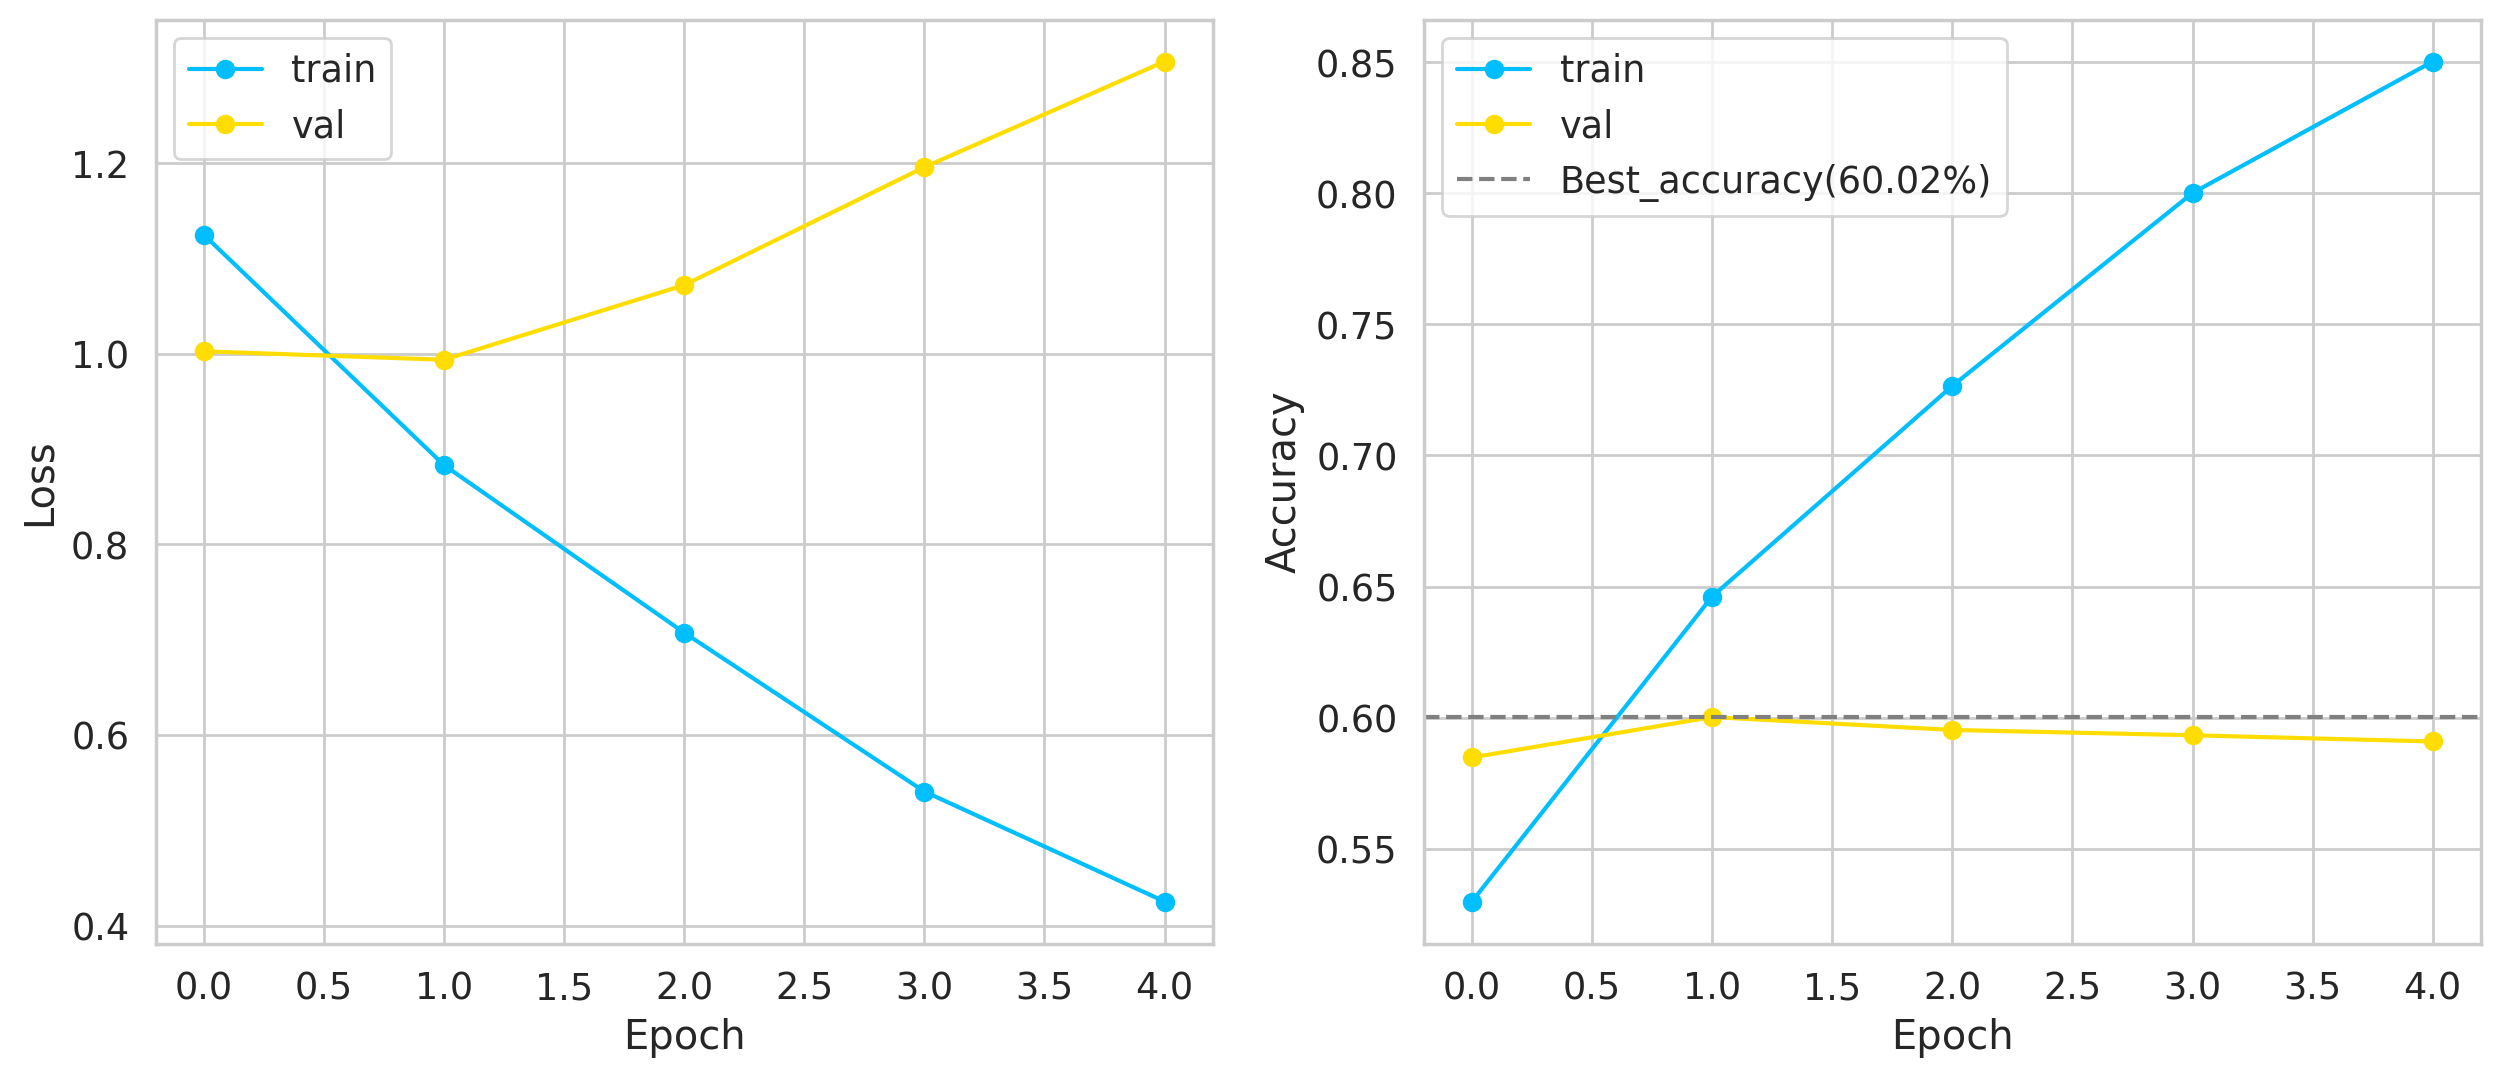

In [ ]:
# Plots
x_epochs = list(range(NUM_EPOCHS))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, history['train_loss'], marker='o', label='train')
plt.plot(x_epochs, history['val_loss'], marker='o', label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, history['train_acc'], marker='o', label='train')
plt.plot(x_epochs, history['val_acc'], marker='o', label='val')
plt.axhline(best_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({best_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

TEST

In [ ]:
y_preds, y_true = test(model,dataloaders['test'], device)

In [ ]:
# Test sentiment prediction
# pred = model.predict(x_test)
# pred[:5]

#test_text = "The movie was great and I really enjoyed the performances of the actors."
#pred_sentiment = test(model,dataloaders['test_text'], device)

print(f"Predicted sentiment: {pred_sentiment}")

# pred_sentiment = model.predict(x_test)

Confusion Matrix

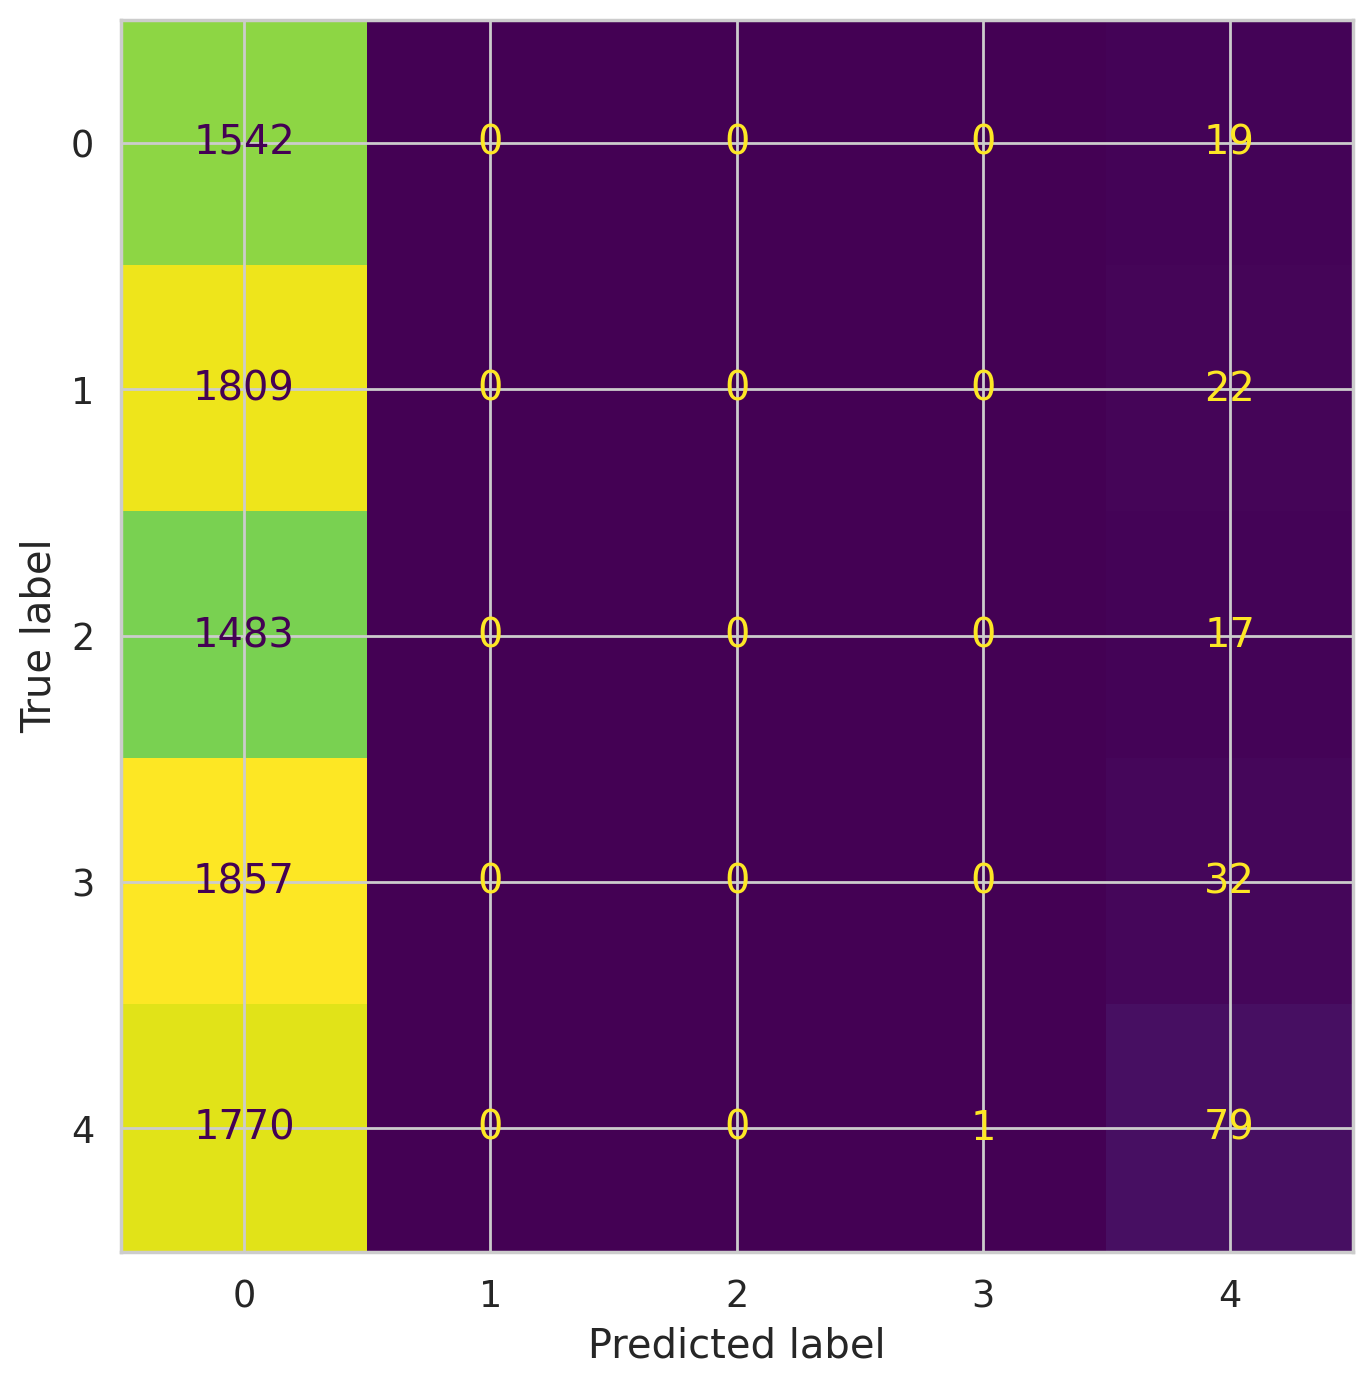

In [ ]:
# Display confusion matrix
_ , ax = plt.subplots(figsize=(8,8))
cm = ConfusionMatrixDisplay.from_predictions(torch.tensor(y_true), torch.tensor(y_preds), ax = ax, colorbar = False);

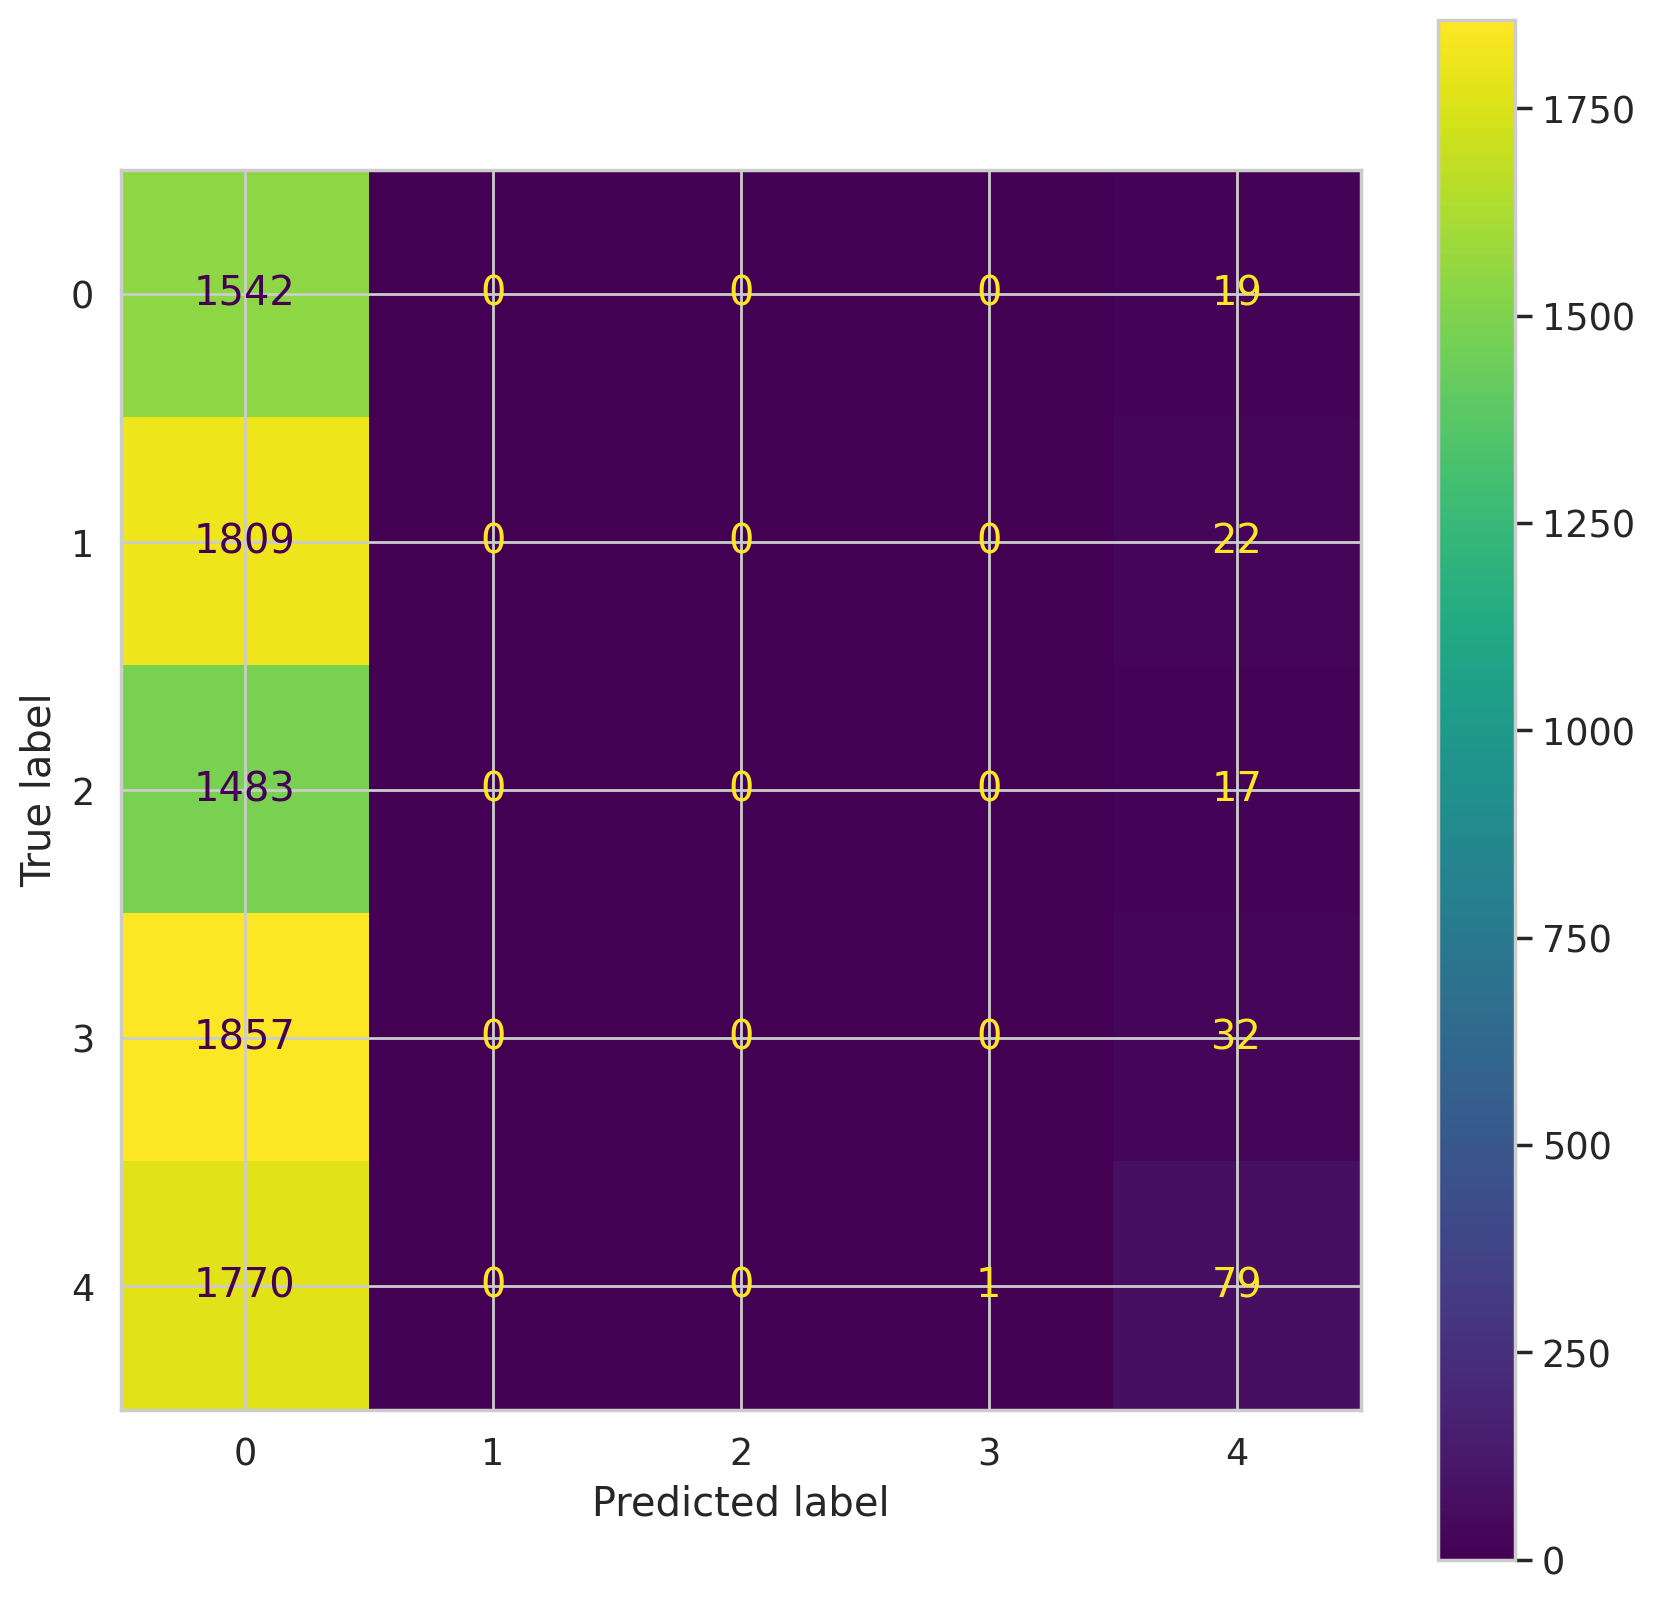

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Convert PyTorch tensors to NumPy arrays
y_true = torch.tensor(y_true)
y_preds = torch.tensor(y_preds)

y_true_np = y_true.cpu().numpy()
y_preds_np = y_preds.cpu().numpy()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_np, y_preds_np)
class_names = ["0", "1", "2", "3", "4"]

# Display confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(ax=ax)
plt.show()


MAE

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_preds)

2.043216313289306

MSE

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true, y_preds)

6.184335534700498

In [ ]:
y_preds = y_preds.float()
y_true = y_true.float()

# Calculate the mean-squared error.
mse = ((y_true - y_preds) ** 2).mean()
mse

tensor(6.1843)

RMSE

In [ ]:
rmse = np.sqrt(mse)
rmse

tensor(1.0748)

REPORTING

In [ ]:
print(classification_report(torch.tensor(y_true), torch.tensor(y_preds)))

              precision    recall  f1-score   support

         0.0       0.18      0.99      0.31      1561
         1.0       0.00      0.00      0.00      1831
         2.0       0.00      0.00      0.00      1500
         3.0       0.00      0.00      0.00      1889
         4.0       0.47      0.04      0.08      1850

    accuracy                           0.19      8631
   macro avg       0.13      0.21      0.08      8631
weighted avg       0.13      0.19      0.07      8631



<ipython-input-57-1c424400becb>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(classification_report(torch.tensor(y_true), torch.tensor(y_preds)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classificati

classification report

In [ ]:
#print(classification_report(val_labels, pred_sentiment, target_names = ['Bad Reviews','Good Reviews']))

Heat Map

In [ ]:
#plt.figure(figsize = (10,10))
#sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
#plt.xlabel("Predicted")
#plt.ylabel("Actual")

Save Model

In [ ]:
#Save the model
torch.save(model.state_dict(), "bert_classifier.pth")